## Andrej Karpathy
[Introduction to neural networks and backpropagation](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=23&t=228s)
### Derivatives


In [57]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
def f(x):
    return 3*x**2 - 4*x + 5

In [59]:
f(3.0)

20.0

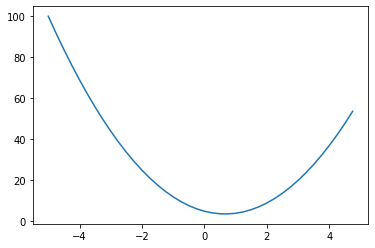

In [60]:
xs = np.arange(-5, 5, 0.25)  # tab from -5 to 5 with step of 0.25
ys = f(xs)
plt.plot(xs, ys)

From [definition](https://en.wikipedia.org/wiki/Derivative).
What interest us? We want to know how much the function will respond if we take a tiny step on x-axis. Will the value increase or decrease? By how much (how quickly let's say)
Derivative can tell us the speed of that change.

In [61]:
h = 0.000000001
x = 3.0
function_response = f(x + h) - f(x)  # to the tiny step in positive dir
slope = function_response/h  # normalize by step
slope  # in other words, the derivative at point x=3

14.000001158365194

Let's get more complex. Function will be dependent on three inputs. We would like to know how it will behave when we will change only one of the variables.

In [62]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [63]:
d1 = a*b + c
a += h  # increase only a (try other variables to see the derivative)
d2 = a*b + c
slope = (d2 - d1)/h
print('d1', d1)
print('d2', d2)
slope # change of the function when we increase a

# we can examine how this function will behave with respect to all the inputs (a, b or c) too

d1 4.0
d2 3.9999699999999994


-3.000000000064062

## Value Object

In [95]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # variable which holds value of the gradient with respect to L, initially 0 (no effect on L, so changing the value do not change the loss function)
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):  # Python will call this internally when we use '+' on the obj
        out = Value(self.data + other.data, (self, other), '+')  # pass children of the operation
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):  # Python will call this internally when we use '*' on the obj
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward
        return out

    # We do not have to implement all the 'basic' operations. We can operate on different levels of abstraction in the graph, because the only thing we need is to know how to differentiate function we are using at local level
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
# a.__add__(b) == a + b
a + b
# (a.__mul__(b)).__add__(c)
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label="L"
L

Value(data=-8.0)

## Visualization

Install:
* sudo apt-get install graphviz
* pip install graphviz

In [65]:
from graphviz import Digraph

# get all nodes and edges of the graph
def trace(root):
    # builds a set of all nodes in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for iter
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to iter
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



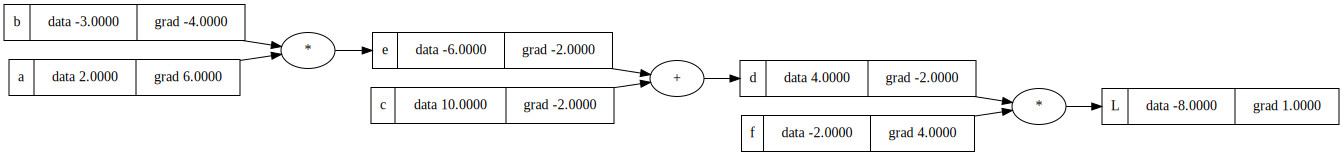

In [78]:
draw_dot(L)

## Derivatives and [chain rule](https://en.wikipedia.org/wiki/Chain_rule)

Idea is to calculate how change of variables *a*, *b*, *c*, *e*, *f*, *d* impacts the change of *L*.
First we calculate **local** derivatives in computation graph:

dL/dd = d*f = f
dL/df = d*f = d
dd/dc = c+e = 1.0
dd/de = c+e = 1.0
de/da = a*b = b = -3.0
de/db = a*b = a = 2.0

These are just local derivatives, what we are really interested in how c and e change L (so derivatives with respect to L: *dL/dc* and *dL/de*)
To calculate them we will use **chain rule**. Chain rule says: *if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man*. Following that logic we need to **multiply** the derivatives along the graph to calculate how *c* and *e* impact the *L*.

dL/dc = (dL/dd) * (dd/dc) = -2.0 * 1.0
dL/de = (dL/dd) * (dd/de) = -2.0 * 1.0
dL/da = (dL/dd) * (dd/de) * (de/da) = -2.0 * 1.0 * -3.0 = 6.0
dL/db = (dL/dd) * (dd/de) * (de/db) = -2.0 * 1.0 * 2.0 = -4.0

In [77]:
L.grad = 1.0  # dL/dL is always eq 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

### Use of gradients

In [68]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass
e = a*b
d = e + c
L = d * f

# Value come up a bit, we nudged it in the direction of the gradients
print(L.data)

-7.286496


## Backpropagation of a Neuron

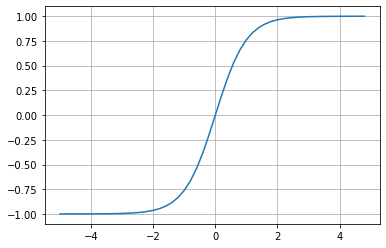

In [69]:
# tang - squashing function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

### Two dimensional neuron

In [96]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813, label='b')

# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh()

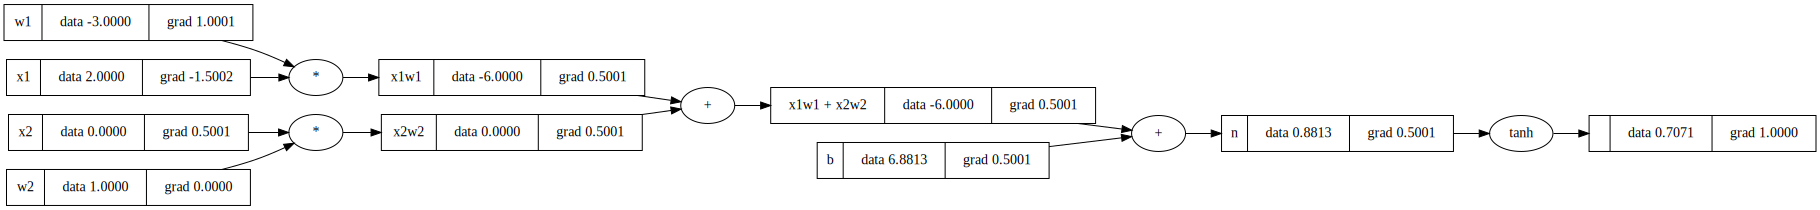

In [102]:
draw_dot(o)

### Neuron manually backprop

In [90]:
o.grad = 1.0
# what is derivative of tanh?
# do/dn = ? = 1 - tanh(n)**2
n.grad = 1 - o.data**2
# dn/db = (x1w1 + x2w2) + b = 1.0 - as we know from previous example, '+' is distributing gradient
b.grad = 1.0 * n.grad
x1w1x2w2.grad = 1.0 * n.grad
# same as above for x1w1 and x2w2
x1w1.grad = 1.0 * 1.0 * n.grad
x2w2.grad = 1.0 * 1.0 * n.grad
# d(x2w2)/dw2 = x2 * w2 = x2
# d(x1w1)/dw1 = x1 * w1 = x1
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

### Neuron automatic backprop

In [101]:
o.grad = 1.0  # initialization of root gradient to 1.0
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()